In [ ]:
! pip install -q imagecodecs
! pip install -q warmup_scheduler
! pip install -q efficientnet_pytorch

In [ ]:
from google.colab import drive 
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
from tqdm import tqdm
tqdm.pandas()

# Deep learning model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet
import albumentations
from sklearn.model_selection import StratifiedKFold

In [ ]:
df = pd.read_csv("drive/MyDrive/DLMI/train_with_tiles.csv")
df["tiles"] = df["tiles"].progress_apply(lambda x : np.array(x.replace("[", "").replace("]", "").split(",")).astype(np.int16).reshape(100, 128, 128, 3))

100%|██████████| 340/340 [13:31<00:00,  2.39s/it]


In [ ]:
skf = StratifiedKFold(5, shuffle=True, random_state=123)
df["fold"] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df, df["isup_grade"])):
    df.loc[valid_idx, "fold"] = i

In [ ]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_pretrained(backbone)

        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [ ]:
class PANDADataset(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        label = row.isup_grade
        return torch.tensor(images), torch.tensor(label)

In [ ]:
transforms_train = albumentations.Compose([albumentations.HorizontalFlip(p=0.5),
                                           albumentations.VerticalFlip(p=0.5),
                                           albumentations.Transpose(p=0.5)])

transforms_val = albumentations.Compose([])

In [ ]:
dataset_show = PANDADataset(df, transform=transforms_train)

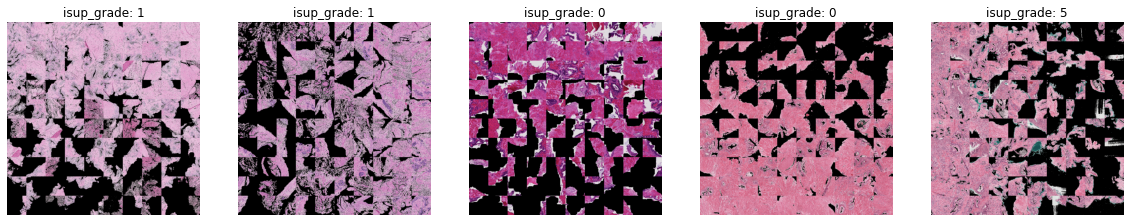

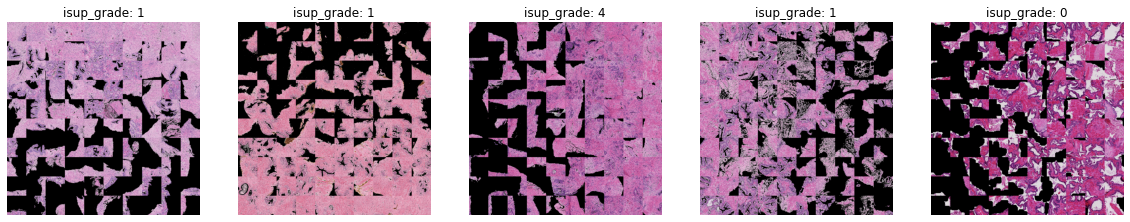

In [ ]:
rcParams["figure.figsize"] = 20, 10
for i in range(2):
    f, axarr = plt.subplots(1, 5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1. - img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title("isup_grade: "+str(label.numpy()))
        axarr[p].axis("off")

In [ ]:
def train(num_epochs, batch_size, criterion, optimizer, model, df, fold):

    train_idx = np.where((df["fold"] != fold))[0]
    valid_idx = np.where((df["fold"] == fold))[0]

    dataset_train = PANDADataset(df.loc[train_idx], transform=transforms_train)
    dataset_valid = PANDADataset(df.loc[valid_idx], transform=transforms_val)

    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=4)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=4)

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs-1)
    scheduler = GradualWarmupScheduler(optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    val_loss_min = 1e20
        
    for epoch in range(1, num_epochs+1):
      
        model.train()
        train_loss = []
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            loss_func = criterion
            optimizer.zero_grad()
            logits = model(data).view(-1)
            loss = loss_func(logits, target.float())
            loss.backward()
            optimizer.step()
            loss_np = loss.detach().cpu().numpy()
            train_loss.append(loss_np)
        train_loss = np.mean(train_loss)
        
        model.eval()
        val_loss = []
        with torch.no_grad():
            for (data, target) in valid_loader:
                data, target = data.to(device), target.to(device)
                logits = model(data).view(-1)
                loss = criterion(logits, target.float())
                val_loss.append(loss.detach().cpu().numpy())
            val_loss = np.mean(val_loss)
        
        scheduler.step()

        if val_loss < val_loss_min:
            print('Epoch [{}/{}], Valid loss ({:.4f} --> {:.4f}).  Saving model ...'.format(epoch, num_epochs, val_loss_min, val_loss))
            torch.save(model.state_dict(), "model_fold_"+str(fold)+".pth")
            val_loss_min = val_loss

In [ ]:
device = torch.device("cuda")
num_epochs = 30
batch_size = 4
init_lr = 3e-4
criterion = nn.MSELoss()

In [ ]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=0)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 5.2686).  Saving model ...
Epoch [2/30], Valid loss (5.2686 --> 3.6687).  Saving model ...
Epoch [4/30], Valid loss (3.6687 --> 1.8342).  Saving model ...
Epoch [5/30], Valid loss (1.8342 --> 1.7492).  Saving model ...
Epoch [7/30], Valid loss (1.7492 --> 1.7344).  Saving model ...
Epoch [9/30], Valid loss (1.7344 --> 1.6797).  Saving model ...
Epoch [11/30], Valid loss (1.6797 --> 1.4413).  Saving model ...
Epoch [12/30], Valid loss (1.4413 --> 1.3153).  Saving model ...
Epoch [22/30], Valid loss (1.3153 --> 1.2521).  Saving model ...
Epoch [24/30], Valid loss (1.2521 --> 1.2217).  Saving model ...


In [ ]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=1)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 6.4625).  Saving model ...
Epoch [2/30], Valid loss (6.4625 --> 2.5977).  Saving model ...
Epoch [4/30], Valid loss (2.5977 --> 2.3000).  Saving model ...
Epoch [6/30], Valid loss (2.3000 --> 1.8950).  Saving model ...
Epoch [7/30], Valid loss (1.8950 --> 1.5944).  Saving model ...
Epoch [13/30], Valid loss (1.5944 --> 1.3885).  Saving model ...
Epoch [21/30], Valid loss (1.3885 --> 1.3171).  Saving model ...
Epoch [24/30], Valid loss (1.3171 --> 1.2424).  Saving model ...


In [ ]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=2)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 4.9036).  Saving model ...
Epoch [3/30], Valid loss (4.9036 --> 2.6225).  Saving model ...
Epoch [5/30], Valid loss (2.6225 --> 1.9497).  Saving model ...
Epoch [6/30], Valid loss (1.9497 --> 1.4165).  Saving model ...
Epoch [9/30], Valid loss (1.4165 --> 1.2754).  Saving model ...
Epoch [16/30], Valid loss (1.2754 --> 1.1653).  Saving model ...


In [ ]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=3)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 6.5125).  Saving model ...
Epoch [2/30], Valid loss (6.5125 --> 2.7431).  Saving model ...
Epoch [3/30], Valid loss (2.7431 --> 1.8997).  Saving model ...
Epoch [5/30], Valid loss (1.8997 --> 1.7020).  Saving model ...
Epoch [8/30], Valid loss (1.7020 --> 1.5122).  Saving model ...
Epoch [10/30], Valid loss (1.5122 --> 1.4671).  Saving model ...
Epoch [14/30], Valid loss (1.4671 --> 1.2852).  Saving model ...


In [ ]:
model = enetv2("efficientnet-b0", out_dim=1)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=init_lr/10)

train(num_epochs, batch_size, criterion, optimizer, model, df, fold=4)

Loaded pretrained weights for efficientnet-b0
Epoch [1/30], Valid loss (100000000000000000000.0000 --> 5.0811).  Saving model ...
Epoch [3/30], Valid loss (5.0811 --> 2.6560).  Saving model ...
Epoch [4/30], Valid loss (2.6560 --> 2.3930).  Saving model ...
Epoch [7/30], Valid loss (2.3930 --> 1.8492).  Saving model ...
Epoch [10/30], Valid loss (1.8492 --> 1.7070).  Saving model ...
Epoch [20/30], Valid loss (1.7070 --> 1.6678).  Saving model ...
Epoch [25/30], Valid loss (1.6678 --> 1.6539).  Saving model ...
Epoch [26/30], Valid loss (1.6539 --> 1.6395).  Saving model ...
Epoch [29/30], Valid loss (1.6395 --> 1.6377).  Saving model ...


In [ ]:
class PANDADatasetPred(Dataset):
    def __init__(self, df, image_size=128, n_tiles=100, transform=None,):
        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index, image_size=128):
        row = self.df.iloc[index]
        tiles = row.tiles
        n_row_tiles = int(np.sqrt(self.n_tiles))
        images = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
                if len(tiles) > i:
                    this_img = tiles[i]
                else:
                    this_img = np.zeros((self.image_size, self.image_size, 3)).astype(np.uint8)
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                images[h1:h1+image_size, w1:w1+image_size] = this_img
        if self.transform is not None:
            images = self.transform(image=images)['image']
        images = images.astype(np.float32)
        images /= 255
        images = images.transpose(2, 0, 1)
        image_id = row.image_id
        return torch.tensor(images), image_id

In [ ]:
df["out_of_fold_predictions"] = None

for fold in range(5):
    model = model = enetv2("efficientnet-b0", out_dim=1)
    model.load_state_dict(torch.load("model_fold_"+str(fold)+".pth"))

    idx = np.where((df["fold"] == fold))[0]
    dataset = PANDADatasetPred(df.loc[idx], transform=transforms_val)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1, sampler=SequentialSampler(dataset))

    model.eval()
    with torch.no_grad():
        for (data, image_id) in tqdm(loader):
            df.loc[df[df["image_id"]==image_id[0]].index[0], "out_of_fold_predictions"] = model(data).numpy()[0][0]

Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [01:46<00:00,  1.57s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:03<00:00,  1.82s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:00<00:00,  1.77s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:00<00:00,  1.77s/it]


Loaded pretrained weights for efficientnet-b0


100%|██████████| 68/68 [02:00<00:00,  1.77s/it]


In [ ]:
df.drop(["tiles", "fold"], axis=1).to_csv("train_clean.csv", index=False)